# SSD training

In [1]:
driveDir = '/content/drive'
from google.colab import drive
drive.mount(driveDir)
driveDir = driveDir + '/My Drive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os

#ssdDir = driveDir + 'NN/ssd_keras/'
ssdDir = driveDir + 'Centria Univ./SSD/'
os.chdir(ssdDir)

In [0]:
import sys
if not 'scripts' in sys.path:
  sys.path.append('scripts') 

In [6]:
!pip install keras==1.2.2
!pip install imageio
!pip install matplotlib 
!pip install pillow
!pip install h5py
!apt install tesseract-ocr
!apt install libtesseract-dev
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fontconfig libcairo2 libdatrie1 libgif7 libjbig0 liblept5 libopenjp2-7
  libpango-1.0-0 libpangocairo-1.0-0 libpangoft2-1.0-0 libpixman-1-0
  libtesseract4 libthai-data libthai0 libtiff5 libwebp6 libxcb-render0
  libxcb-shm0 tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  fontconfig libcairo2 libdatrie1 libgif7 libjbig0 liblept5 libopenjp2-7
  libpango-1.0-0 libpangocairo-1.0-0 libpangoft2-1.0-0 libpixman-1-0
  libtesseract4 libthai-data libthai0 libtiff5 libwebp6 libxcb-render0
  libxcb-shm0 tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 21 newly installed, 0 to remove and 5 not upgraded.
Need to get 8,799 kB of archives.
After this operation, 27.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 fontconfig amd64 2.12.6-0ubuntu2 [169 kB]

## Train data

In [0]:
import glob

from make_data import arrange_data, get_boxes, save_coordinates
from make_xml import Make_XML2

In [0]:
keyword_lst = ["ALK","LR03","LR6","1.5V","1,5V","NI-CD","NICD","NIMH","NI-MH","MHNI","MH-NI","HR14","HR20","LI-ION","LIION","LITHIUM","3,7V","3.7V"]

In [0]:
in_lst = glob.glob(ssdDir + 'Battery_Image/*/*.jpeg')
outpath = ssdDir + 'train_data/coordinates.pkl'

coordinates = arrange_data(get_boxes(in_lst), keyword_lst)
save_coordinates(coordinates, outpath)

In [0]:
import pickle
outpath = ssdDir + 'train_data/coordinates.pkl'
coordinates = pickle.load(open(outpath, 'rb'))

In [0]:
# some constants
voc_classes = ['keyword']
NUM_CLASSES = len(voc_classes) + 1
input_shape=(300, 300, 3)

In [0]:
train_data = ssdDir + 'train_data/coordinates.pkl'
outdir = ssdDir + 'Annotations_org/'
keyword = False

Make_XML2(train_data, outdir, keyword)

In [0]:
import pickle

import sys
if not 'PASCAL_VOC' in sys.path:
  sys.path.append('PASCAL_VOC') 

import get_data_from_XML
from get_data_from_XML import XML_preprocessor

data = XML_preprocessor('Annotations_org/', voc_classes).data
pickle.dump(data,open('BATTERY_org.pkl','wb'),2)

## Tensorboard

In [0]:
!pip install tensorboardcolab

  Running setup.py bdist_wheel for tensorboardcolab ... - done
  Stored in directory: /root/.cache/pip/wheels/ab/74/02/cda602d1dc28b2f12eab313c49b9bfa14d6371326bc2590e06
Successfully built tensorboardcolab


In [0]:
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback

Using TensorFlow backend.


In [0]:
tbc = TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
http://282d2d96.ngrok.io


## Model

In [8]:
import cv2
import keras
from keras.applications.imagenet_utils import preprocess_input
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import pickle
from random import shuffle
from imageio import imread
from scipy.misc import imresize
import tensorflow as tf

from ssd import SSD300
from ssd_training import MultiboxLoss
from ssd_utils import BBoxUtility

import time

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'

np.set_printoptions(suppress=True)

# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.9
# set_session(tf.Session(config=config))

Using TensorFlow backend.


In [0]:
# some constants
voc_classes = ['keyword']
NUM_CLASSES = len(voc_classes) + 1
input_shape=(300, 300, 3)

In [0]:
priors = pickle.load(open('prior_boxes_ssd300.pkl', 'rb'))
bbox_util = BBoxUtility(NUM_CLASSES, priors)

In [0]:
gt = pickle.load(open('train_data/BATTERY_org.pkl', 'rb'))
keys = sorted(gt.keys())
shuffle(keys)
num_train = int(round(0.8 * len(keys)))
train_keys = keys[:num_train]
val_keys = keys[num_train:]
num_val = len(val_keys)

In [0]:
print(len(keys))
print(len(train_keys))
print(len(val_keys))

229
183
46


In [0]:
class Generator(object): 
  def __init__(self, gt, bbox_util,
                 batch_size, path_prefix,
                 train_keys, val_keys, image_size,
                 saturation_var=0.5,
                 brightness_var=0.5,
                 contrast_var=0.5,
                 lighting_std=0.5,
                 hflip_prob=0.5,
                 vflip_prob=0.5,
                 do_crop=True,
                 crop_area_range=[0.8, 1.2],
                 aspect_ratio_range=[3./5., 5./3.]):
        self.gt = gt
        self.bbox_util = bbox_util
        self.batch_size = batch_size
        self.path_prefix = path_prefix
        self.train_keys = train_keys
        self.val_keys = val_keys
        self.train_batches = len(train_keys)
        self.val_batches = len(val_keys)
        self.image_size = image_size
        self.color_jitter = []
        if saturation_var:
            self.saturation_var = saturation_var
            self.color_jitter.append(self.saturation)
        if brightness_var:
            self.brightness_var = brightness_var
            self.color_jitter.append(self.brightness)
        if contrast_var:
            self.contrast_var = contrast_var
            self.color_jitter.append(self.contrast)
        self.lighting_std = lighting_std
        self.hflip_prob = hflip_prob
        self.vflip_prob = vflip_prob
        self.do_crop = do_crop
        self.crop_area_range = crop_area_range
        self.aspect_ratio_range = aspect_ratio_range
        
  def grayscale(self, rgb):
    return rgb.dot([0.299, 0.587, 0.114])

  def saturation(self, rgb):
    gs = self.grayscale(rgb)
    alpha = 2 * np.random.random() * self.saturation_var 
    alpha += 1 - self.saturation_var
    rgb = rgb * alpha + (1 - alpha) * gs[:, :, None]
    return np.clip(rgb, 0, 255)

  def brightness(self, rgb):
    alpha = 2 * np.random.random() * self.brightness_var 
    alpha += 1 - self.saturation_var
    rgb = rgb * alpha
    return np.clip(rgb, 0, 255)

  def contrast(self, rgb):
    gs = self.grayscale(rgb).mean() * np.ones_like(rgb)
    alpha = 2 * np.random.random() * self.contrast_var 
    alpha += 1 - self.contrast_var
    rgb = rgb * alpha + (1 - alpha) * gs
    return np.clip(rgb, 0, 255)

  def lighting(self, img):
    cov = np.cov(img.reshape(-1, 3) / 255.0, rowvar=False)
    eigval, eigvec = np.linalg.eigh(cov)
    noise = np.random.randn(3) * self.lighting_std
    noise = eigvec.dot(eigval * noise) * 255
    img += noise
    return np.clip(img, 0, 255)

  def horizontal_flip(self, img, y):
    if np.random.random() < self.hflip_prob:
        img = img[:, ::-1]
        y[:, [0, 2]] = 1 - y[:, [2, 0]]
    return img, y

  def vertical_flip(self, img, y):
    if np.random.random() < self.vflip_prob:
        img = img[::-1]
        y[:, [1, 3]] = 1 - y[:, [3, 1]]
    return img, y

  def random_sized_crop(self, img, targets):
    img_w = img.shape[1]
    img_h = img.shape[0]
    img_area = img_w * img_h
    random_scale = np.random.random()
    random_scale *= (self.crop_area_range[1] -
                     self.crop_area_range[0])
    random_scale += self.crop_area_range[0]
    target_area = random_scale * img_area
    random_ratio = np.random.random()
    random_ratio *= (self.aspect_ratio_range[1] -
                     self.aspect_ratio_range[0])
    random_ratio += self.aspect_ratio_range[0]
    w = np.round(np.sqrt(target_area * random_ratio))     
    h = np.round(np.sqrt(target_area / random_ratio))
    if np.random.random() < 0.5:
        w, h = h, w
    w = min(w, img_w)
    w_rel = w / img_w
    w = int(w)
    h = min(h, img_h)
    h_rel = h / img_h
    h = int(h)
    x = np.random.random() * (img_w - w)
    x_rel = x / img_w
    x = int(x)
    y = np.random.random() * (img_h - h)
    y_rel = y / img_h
    y = int(y)
    img = img[y:y+h, x:x+w]
    new_targets = []
    for box in targets:
        cx = 0.5 * (box[0] + box[2])
        cy = 0.5 * (box[1] + box[3])
        if (x_rel < cx < x_rel + w_rel and
            y_rel < cy < y_rel + h_rel):
            xmin = (box[0] - x_rel) / w_rel
            ymin = (box[1] - y_rel) / h_rel
            xmax = (box[2] - x_rel) / w_rel
            ymax = (box[3] - y_rel) / h_rel
            xmin = max(0, xmin)
            ymin = max(0, ymin)
            xmax = min(1, xmax)
            ymax = min(1, ymax)
            box[:4] = [xmin, ymin, xmax, ymax]
            new_targets.append(box)
    new_targets = np.asarray(new_targets).reshape(-1, targets.shape[1])
    return img, new_targets

  def generate(self, train=True):
    while True:
        if train:
            shuffle(self.train_keys)
            keys = self.train_keys
        else:
            shuffle(self.val_keys)
            keys = self.val_keys
        inputs = []
        targets = []
        for key in keys:   
            head, tail = os.path.split(key.replace("_", "/"))
            dir_name = head.replace("/", "_") + "/"
            img_path = self.path_prefix + dir_name + key
            #img_path = self.path_prefix + key
            img = imread(img_path).astype('float32')
            y = self.gt[key].copy()
            if train and self.do_crop:
                img, y = self.random_sized_crop(img, y)
            img = imresize(img, self.image_size).astype('float32')
            if train:
                shuffle(self.color_jitter)
                for jitter in self.color_jitter:
                    img = jitter(img)
                if self.lighting_std:
                    img = self.lighting(img)
                if self.hflip_prob > 0:
                    img, y = self.horizontal_flip(img, y)
                if self.vflip_prob > 0:
                    img, y = self.vertical_flip(img, y)
            y = self.bbox_util.assign_boxes(y)
            inputs.append(img)                
            targets.append(y)
            if len(targets) == self.batch_size:
                tmp_inp = np.array(inputs)
                tmp_targets = np.array(targets)
                inputs = []
                targets = []
                yield preprocess_input(tmp_inp), tmp_targets

In [0]:
path_prefix = ssdDir + 'Battery_Image/'
gen = Generator(gt, bbox_util, 4, path_prefix,
                train_keys, val_keys,
                (input_shape[0], input_shape[1]), do_crop=False)

In [0]:
model = SSD300(input_shape, num_classes=NUM_CLASSES)
model.load_weights('models/weights_SSD300.hdf5', by_name=True)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
dim is deprecated, use axis instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [0]:
freeze = ['input_1', 'conv1_1', 'conv1_2', 'pool1',
          'conv2_1', 'conv2_2', 'pool2',
          'conv3_1', 'conv3_2', 'conv3_3', 'pool3']#,
#          'conv4_1', 'conv4_2', 'conv4_3', 'pool4',
#          'conv5_1', 'conv5_2', 'conv5_3', 'pool5']

for L in model.layers:
    if L.name in freeze:
        L.trainable = False

In [0]:
def schedule(epoch, decay=0.9):
    return base_lr * decay**(epoch)

callbacks = [keras.callbacks.LearningRateScheduler(schedule), TensorBoardColabCallback(tbc)]

In [0]:
base_lr = 3e-4
optim = keras.optimizers.Adam(lr=base_lr)
# optim = keras.optimizers.RMSprop(lr=base_lr)
# optim = keras.optimizers.SGD(lr=base_lr, momentum=0.9, decay=decay, nesterov=True)
model.compile(optimizer=optim,
              loss=MultiboxLoss(NUM_CLASSES, neg_pos_ratio=3.0).compute_loss, metrics=['accuracy'])

## Train

In [0]:
start = time.time()

nb_epoch = 50
history = model.fit_generator(gen.generate(True), gen.train_batches,
                              nb_epoch, verbose=1,
                              callbacks=callbacks,
                              validation_data=gen.generate(False),
                              nb_val_samples=gen.val_batches,
                              nb_worker=1)

print("=== END ===")
print(time.time()-start)

/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/50


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:151: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


180/183 [============================>.] - ETA: 2s - loss: 3.7053 - acc: 0.5488

/usr/local/lib/python2.7/dist-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


184/183 [==============================] - 187s - loss: 3.6713 - acc: 0.5486 - val_loss: 2.6353 - val_acc: 0.5166
Epoch 2/50
184/183 [==============================] - 22s - loss: 2.3937 - acc: 0.4800 - val_loss: 2.4398 - val_acc: 0.5700
Epoch 3/50
184/183 [==============================] - 22s - loss: 2.1554 - acc: 0.5106 - val_loss: 1.9869 - val_acc: 0.4882
Epoch 4/50
184/183 [==============================] - 22s - loss: 1.7365 - acc: 0.4966 - val_loss: 2.0383 - val_acc: 0.4782
Epoch 5/50
184/183 [==============================] - 22s - loss: 1.5541 - acc: 0.4848 - val_loss: 1.6069 - val_acc: 0.5090
Epoch 6/50
184/183 [==============================] - 22s - loss: 1.4731 - acc: 0.5053 - val_loss: 1.6579 - val_acc: 0.4976
Epoch 7/50
184/183 [==============================] - 22s - loss: 1.3246 - acc: 0.5056 - val_loss: 1.5596 - val_acc: 0.5316
Epoch 8/50
184/183 [==============================] - 22s - loss: 1.2314 - acc: 0.4876 - val_loss: 1.3802 - val_acc: 0.4932
Epoch 9/50
184/183

## Save

In [0]:
model.save_weights('models/param_org.hdf5')

## Prediction

In [0]:
model = SSD300(input_shape, num_classes=NUM_CLASSES)
model.load_weights('models/param_org.hdf5', by_name=True)

In [0]:
inputs = []
images = []
key = sorted(keys)[0]
head, tail = os.path.split(key.replace("_", "/"))
dir_name = head.replace("/", "_") + "/"
img_path = path_prefix + dir_name + key
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
images.append(imread(img_path))
inputs.append(img.copy())
inputs = preprocess_input(np.array(inputs))

In [0]:
preds = model.predict(inputs, batch_size=1, verbose=1)
results = bbox_util.detection_out(preds)

1/1 [==============================] - 1s


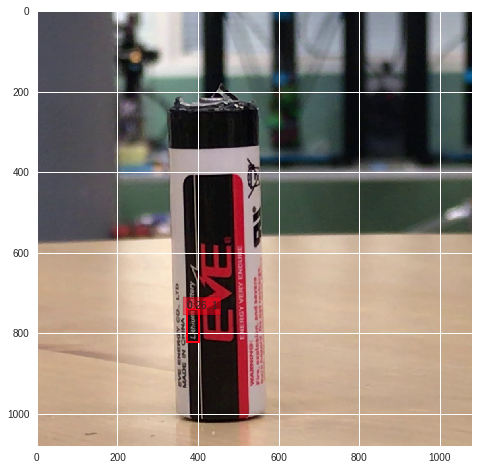

In [0]:
for i, img in enumerate(images):
    # Parse the outputs.
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]

    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.2][:3]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    colors = plt.cm.hsv(np.linspace(0, 1, NUM_CLASSES)).tolist()

    plt.imshow(img / 255.)
    currentAxis = plt.gca()

    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
#         label_name = voc_classes[label - 1]
        display_txt = '{:0.2f}, {}'.format(score, label)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[label]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
    
    plt.show()

In [0]:
import glob

new_lst = glob.glob(ssdDir + "Battery_Image/*.JPG")

/content/drive/My Drive/Centria Univ./SSD/Battery_Image/DSC_0525.JPG
1/1 [==============================] - 0s


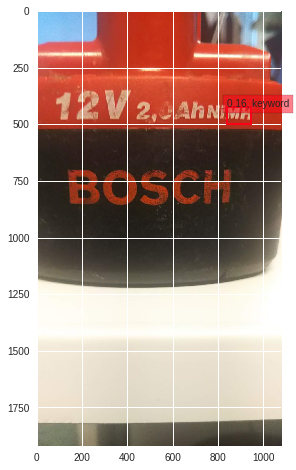

/content/drive/My Drive/Centria Univ./SSD/Battery_Image/DSC_0526.JPG
1/1 [==============================] - 0s


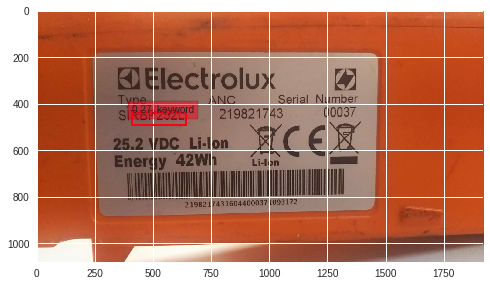

/content/drive/My Drive/Centria Univ./SSD/Battery_Image/DSC_0527.JPG
1/1 [==============================] - 0s


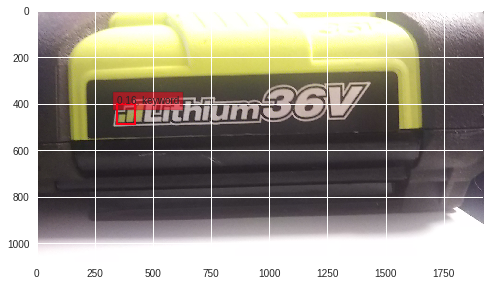

/content/drive/My Drive/Centria Univ./SSD/Battery_Image/DSC_0529.JPG
1/1 [==============================] - 0s


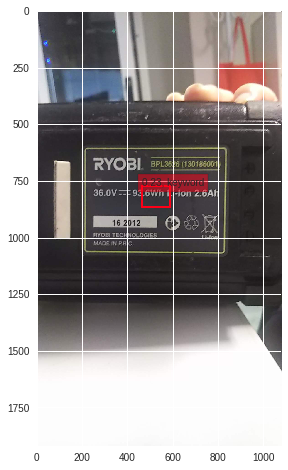

In [0]:
for i in range(len(new_lst)):
  inputs = []
  images = []
  img_path = sorted(new_lst)[i]
  print(img_path)
  img = image.load_img(img_path, target_size=(input_shape[0], input_shape[1]))
  img = image.img_to_array(img)
  images.append(imread(img_path))
  inputs.append(img.copy())
  inputs = preprocess_input(np.array(inputs))
  
  preds = model.predict(inputs, batch_size=1, verbose=1)
  results = bbox_util.detection_out(preds)
  
  for i, img in enumerate(images):
    # Parse the outputs.
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]

    # Get detections with confidence higher than 0.4.
    #top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.1]
    
    top_indices = [0]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    colors = plt.cm.hsv(np.linspace(0, 1, NUM_CLASSES)).tolist()

    plt.imshow(img / 255.)
    currentAxis = plt.gca()

    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
        label_name = voc_classes[label - 1]
        display_txt = '{:0.2f}, {}'.format(score, label_name)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[label]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
    
    plt.show()